# **Assignment 1**

#### **MSc** Scientific and Data Intensive Computing, University College London, 2021-2022

#### Techniques of High Performance Computing (PHAS0102)

####**Cong Zheng (Student ID: 21055428)**

## Table of Contents
1. [Introduction](#introduction)
2. [Question 1](#question1)
3. [Question 2](#question2)
4. [Question 3](#question3)
5. [Question 4](#question4)
6. [Conclusion](#conclusion)
7. [Reference](#reference)

## Introduction
<a id="introduction"></a>

Matrix product is one of the most basic operations on modern computers. Most algorithms will eventually use this operation. Therefore, a lot of effort is spent on optimizing the matrix product.

Matrix optimization, block division and its application have aroused extensive discussion among scholars around the world. Jiaquan Gao et al. proposed a novel multi-GPU parallel SpMV optimization framework, which performs matrix partitioning on a specific multi-GPU platform, thereby greatly improving the performance of SpMV [1]. Ahmad Abdelfattah et al. proposed a GPU-accelerated SpMV kernel for block sparse matrix, which can effectively improve hardware utilization in dense BLAS operations [2]. The matrix block algorithm also has application value in the communication field. Tania Malik's research team used parallel matrix multiplication to solve the problem of efficiently executing data parallel applications on interconnected clusters and optimized data partitioning [3].

In this assignment, it is hoped to explore the computational performance optimization effect provided by Numba through matrix multiplication. First, in question 1, we explored the performance trend of the matrix multiplication program when the matrix dimension n changes from 100 to 300. Subsequently, in questions 2 and 3, we conducted a comparative analysis of the performance of parallel and serial JIT compilation in Numba when the matrix size n ranges from 100 to 600, and further discussed the effect of column-first matrix multiplication on the cache efficiency Optimization effect. Finally, in question 4, the optimization effect of the block matrix algorithm combined with JIT compilation in Numba is discussed, and the influence of the selection of the block matrix size ℓ on the optimization is further analyzed.

## Question 1
<a id="question1"></a>

First, in question 1, we explored the performance trend of the matrix multiplication program when the matrix dimension n changes from 100 to 300.

In [ ]:
# Importing libraries.
import numpy as np
import matplotlib.pyplot as plt

from numba import jit
from numba import prange

# Magic command to keep plots in the notebook.
%matplotlib inline

In [ ]:
def matrix_product(mat_a, mat_b):
    """Returns the product of the matrices mat_a and mat_b."""
    m = mat_a.shape[0]
    n = mat_b.shape[1]

    assert(mat_a.shape[1] == mat_b.shape[0])

    ncol = mat_a.shape[1]
    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in range(m):
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]
    return mat_c

In order to explore the calculation performance of the matrix multiplication function, we set the matrix size n to be 5 points from 100 to 300. In order to reflect the computational performance of the algorithm, we introduced the dot product function a@b in Numpy and conducted benchmark tests respectively.

In [ ]:
timeit_result1 = np.zeros(5, dtype=np.float64)
timeit_result2 = np.zeros(5, dtype=np.float64)

for loop in range(100, 350, 50):
    a = np.random.randn(loop, loop)
    b = np.random.randn(loop, loop)
    c_actual = matrix_product(a, b)
    c_expected = a @ b
    timeit_result_1 = %timeit -o matrix_product(a, b)
    timeit_result_2 = %timeit -o a @ b
    timeit_result1[int(loop/50 -2)] = timeit_result_1.best
    timeit_result2[int(loop/50 -2)] = timeit_result_2.best

In order to more intuitively show the performance difference between the unoptimized matrix multiplication and the numpy matrix dot multiplication algorithm, we have drawn the comparison diagrams of their timing results, as shown below.

In [ ]:
def plot_lines(result1, l1, result2, l2, t, maxrange):
    x_fit = range(100, maxrange, 50)
    plt.figure(figsize=(10,4))
    plt.plot(x_fit,result1,
         ':',label=l1,color='skyblue', marker = 'o')
    plt.plot(x_fit,result2,
         ':',label=l2,color='maroon', marker = 'o')
    plt.xlabel('Matrix Dimension n')
    plt.ylabel('Time Consuming')
    plt.title(t)
    plt.legend()
    plt.show()

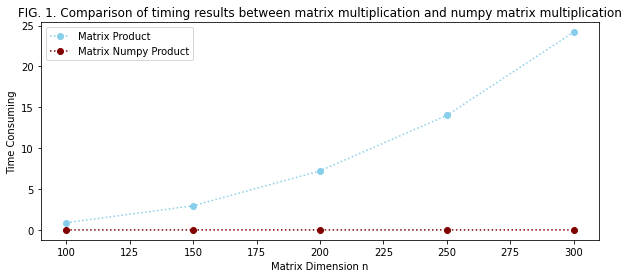

In [ ]:
plot_lines(timeit_result1,'Matrix Product',
           timeit_result2,'Matrix Numpy Product',
   'FIG. 1. Comparison of timing results between matrix and numpy matrix multiplication', 
   350)

Observing Figure 1 shows that the performance of matrix multiplication without any optimization lags far behind that of numpy matrix multiplication. Specifically, the calculation time of the two is not in the same order of magnitude. When the matrix size n is 200, the numpy matrix multiplication requires only 954 µs, and the unoptimized matrix multiplication requires 7.22 s operation time, which is almost 10^4 times the former. In addition, with the increase of the matrix size n, the time required by the two algorithms shows an upward trend similar to the index.

In short, the unoptimized matrix multiplication has a huge room for improvement in computing performance due to the high complexity of the algorithm.

## Question 2
<a id="question2"></a>

In order to explore the impact of compilation on performance optimization in Numba, we use JIT compilation to optimize the code. In addition, because the code contains a triple for loop, there is room for parallelization.

Therefore, we benchmarked JIT-compiled serial code against JIT-compiled parallel code.

In [ ]:
@jit(nopython=True, parallel=False)
def matrix_serial_JIT_product(mat_a, mat_b):
    """Returns the product of the matrices mat_a and mat_b."""
    m = mat_a.shape[0]
    n = mat_b.shape[1]

    assert(mat_a.shape[1] == mat_b.shape[0])

    ncol = mat_a.shape[1]

    mat_c = np.zeros((m, n), dtype=np.float64)
    
    for row_ind in range(m):
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]

    return mat_c

In [ ]:
@jit(nopython=True, parallel=True)
def matrix_parallel_JIT_product(mat_a, mat_b):
    """Returns the product of the matrices mat_a and mat_b."""
    m = mat_a.shape[0]
    n = mat_b.shape[1]

    assert(mat_a.shape[1] == mat_b.shape[0])

    ncol = mat_a.shape[1]
    
    mat_c = np.zeros((m, n), dtype=np.float64)
   
    for row_ind in prange(m):
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]

    return mat_c

In order to more intuitively show the difference in computing performance between parallelization and serialization JIT optimization in Numba, a schematic diagram of their performance comparison is drawn, as shown in Figure 2.

In [ ]:
timeit_serial_results = np.zeros(10, dtype=np.float64)
timeit_parallel_results = np.zeros(10, dtype=np.float64)

for loop in range(100, 600, 50):
    a = np.random.randn(loop, loop)
    b = np.random.randn(loop, loop)

    c_serial = matrix_serial_JIT_product(a, b)
    c_parallel = matrix_parallel_JIT_product(a, b)

    timeit_serial_result = %timeit -o matrix_serial_JIT_product(a, b)
    timeit_serial_results[int(loop/50 -2)] = timeit_serial_result.best

    timeit_parallel_result = %timeit -o matrix_parallel_JIT_product(a, b) 
    timeit_parallel_results[int(loop/50 -2)] = timeit_parallel_result.best

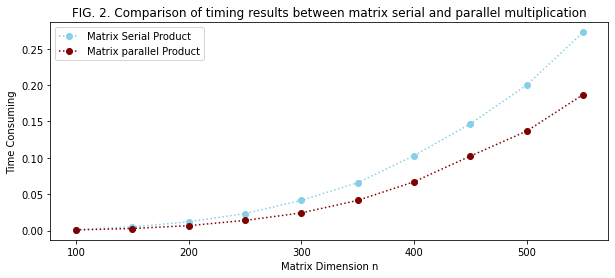

In [ ]:
plot_lines(timeit_serial_results,'Matrix Serial Product',
           timeit_parallel_results, 'Matrix parallel Product',
  'FIG. 2. Comparison of timing results between matrix serial and parallel multiplication', 600)





Observing Figure 2 can be obtained, after the JIT compilation optimization in Numba, the calculation performance of matrix multiplication has been greatly improved, and the parallel operation has further improved the performance. Specifically, when the matrix size n is 300, the serialized code and parallelized code optimized by JIT compilation in numba require 41.5 ms and 24.2 ms, respectively, while the unoptimized matrix multiplication requires 24.2 s, which reflects Numba The JIT compilation in, reduces the computing time by an order of magnitude of 10^3. In addition, with the increase of the matrix size n, the time required for parallelization is shorter than serialization, showing a more obvious optimization effect.

In short, the performance of matrix multiplication after JIT compilation and optimization in Numba has been greatly improved, and the optimization effect of parallelization is more obvious than that of serialization

## Question 3
<a id="question3"></a>

Since 𝐵 in the matrix is traversed by column, but the default storage order in Numpy is based on rows, the code has room for further optimization due to the jump of unit address in memory.

Therefore, we run the parallelized JIT compiled Numba code again, and select the matrix 𝐵 to store in column-major order.

In [ ]:
timeit_fortran_results = np.zeros(10, dtype=np.float64)

for loop in range(100, 600, 50):
    a = np.random.randn(loop, loop)
    b = np.random.randn(loop, loop)
    b1 = np.asfortranarray(b)

    c_fortran = matrix_parallel_JIT_product(a, b1)
    timeit_fortran_result = %timeit -o matrix_parallel_JIT_product(a, b1) 
    timeit_fortran_results[int(loop/50 -2)] = timeit_fortran_result.best

In order to reflect the improvement of the program operation performance by the column-first operation, we have drawn the comparison diagram of the matrix multiplication performance of the row-first and column-first matrix multiplications of the B matrix under the same parallel JIT compilation conditions, as shown in Figure 3.

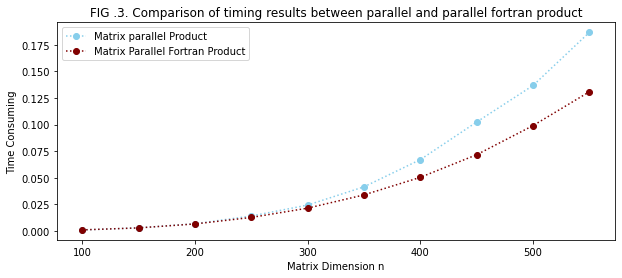

In [ ]:
plot_lines(timeit_parallel_results,'Matrix parallel Product',
           timeit_fortran_results,'Matrix Parallel Fortran Product',
'FIG .3. Comparison of timing results between parallel and parallel fortran product', 600)

Observing Figure 2 can be obtained, after the JIT compilation optimization in Numba, the calculation performance of matrix multiplication has been greatly improved, and the parallel operation has further improved the performance.

Specifically, when the matrix size n is 400, the parallelized code after JIT compilation and optimization in numba takes 67ms, while the matrix multiplication with B matrix column priority processing takes 50.3ms, which reflects the effect of column-first matrix B on the multiplication operation. The reason is that if the column first operation is not performed on matrix B, the addresses that the CPU needs to address in the memory are not continuous, which leads to time-consuming instability, and the graph lines are jagged. After the column first operation, the graph line is smoother and the time-consuming is lower.

In short, due to the improvement of cache efficiency, the performance of column-first parallelized matrix multiplication has been further improved.

## Question 4
<a id="question4"></a>

A common technique to further improve the efficiency of matrix-matrix product is block division. Specifically, it changes the multiplication and accumulation between individual elements into the multiplication and accumulation of different ℓ×ℓ sub-matrices.

In question 4, we separately analyzed the optimization effect of block division and Numba's optimization effect of block operation, and discussed the influence of the choice of sub-matrix size ℓ on the calculation performance.

### 4.1 Comparison of optimization performance of blocking or not

According to the matrix block multiplication principle of [Discussion on Program Performance Optimization](https://blog.csdn.net/u013471946/article/details/43957423?utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1.no_search_link&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1.no_search_link), we have written the matrix block multiplication program, as shown below. It is worth noting that, in order to eliminate the consideration of the corner parts of the matrix that cannot be divided, the program does not perform operations on the parts that cannot be divided. Therefore, the parameter bsize must be divisible by n.

In [ ]:
@jit(nopython=True, parallel = True)
def matrix_block_product(A, B, n, bsize):
    sum = 0.0
    C = np.zeros((n, n), dtype=np.float64)
    for kk in prange(0, int(n/bsize), 1): 
        for cc in prange(0, int(n/bsize), 1):
            for r in prange(0, n, 1):
                for c in prange(cc*bsize, (cc+1)*bsize, 1):
                    sum = C[r][c]
                    for k in prange(kk*bsize, (kk+1)*bsize, 1):
                         sum += A[r][k]*B[k][c]
                    C[r][c] = sum
    return C

In order to explore the calculation performance of the matrix block multiplication function, we selected 10 points in the matrix size n from 100 to 600 and performed a benchmark test.

In [ ]:
timeit_block_results = np.zeros(10, dtype=np.float64)

for loop in range(100, 600, 50):
    a = np.random.randn(loop, loop)
    b = np.random.randn(loop, loop)
    b1 = np.asfortranarray(b)
    c_block = matrix_block_product(a, b1, loop, 50)
    timeit_block_result = %timeit -o matrix_block_product(a, b1, loop, 50) 
    timeit_block_results[int(loop/50 -2)] = timeit_block_result.best

In order to compare the calculation performance difference of matrix block or not based on Numba's parallel JIT compilation more intuitively, a schematic diagram of their performance comparison is drawn, as shown in the figure 4.

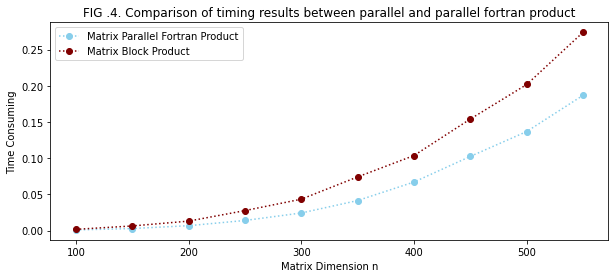

In [ ]:
plot_lines(timeit_parallel_results,'Matrix Parallel Fortran Product',
           timeit_block_results,'Matrix Block Product',
'FIG .4. Comparison of timing results between parallel and parallel fortran product', 600)

From the image, in the case of Numba parallel JIT optimization and B matrix column priority, the optimization effect of matrix block multiplication on the calculation time seems to be not as good as that of unblocked matrix multiplication. This may be due to the high complexity of the matrix block multiplication algorithm.

# 4.2 Numba's discussion on the optimization and improvement of matrix block multiplication performance

Since it is not clear whether the Numba implementation in matrix block multiplication has advantages, in this section, we compare and analyze the matrix block multiplication performance before and after numba optimization. Five samples with a matrix size n ranging from 100 to 300 are selected, and the sub-matrix size ℓ is all selected as 50.


In [ ]:
def matrix_block_nonumba_product(A, B, n, bsize):
    sum = 0.0

    C = np.zeros((n, n), dtype=np.float64)
    for kk in range(0, n, bsize): 
        for cc in range(0, n, bsize):
            for r in prange(0, n, 1):
                for c in range(cc, cc+bsize, 1):
                    sum = C[r][c]
                    for k in range(kk, kk+bsize, 1):
                         sum += A[r][k]*B[k][c]
                    C[r][c] = sum 
    return C

In [ ]:
timeit_block_nonumba_results = np.zeros(5, dtype=np.float64)

for loop in range(100, 350, 50):
    a = np.random.randn(loop, loop)
    b = np.random.randn(loop, loop)
    c = np.random.randn(loop, loop)

    c_block = matrix_block_nonumba_product(a, b, loop, 50)
    timeit_block_nonumba_result = %timeit -o matrix_block_nonumba_product(a, b, loop, 50) 
    timeit_block_nonumba_results[int(loop/50 -2)] = timeit_block_nonumba_result.best

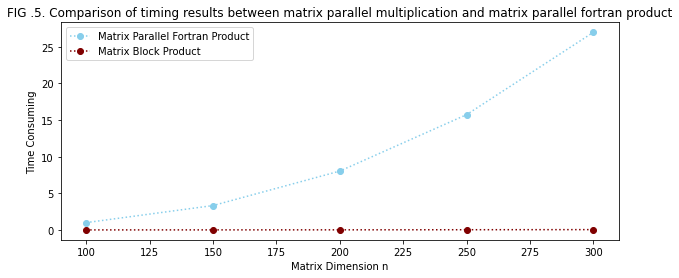

In [ ]:
plot_lines(timeit_block_nonumba_results,'Matrix Parallel Fortran Product',
           timeit_block_results[0:5],'Matrix Block Product',
  'FIG .5. Comparison of timing results between matrix parallel fortran and block product', 350)

From the image, the calculation time of the two is not in the same order. Specifically, when the matrix size n is 200, the numba-optimized matrix block multiplication only needs 13 ms, while the unoptimized matrix block multiplication requires 8.04 s of operation time, which is almost 10^1 of the former Times. And the order of magnitude of this gap will increase substantially as the matrix size n increases. Therefore, the optimization effect of Numba optimization for matrix block multiplication is very obvious.

#4.3 The selection of block size ℓ discusses the optimization effect

In the discussion in Section 4.1 and Section 4.2, the selected sub-matrix size ℓ is 50. In this section, the influence of different sub-matrix sizes ℓ on the performance of matrix block operations is further discussed. We set the matrix size n to 500, and selected 10 different ℓ (these ℓ can be divisible by 500) to analyze the selection strategy of ℓ that maximizes the performance.

In [ ]:
timeit_block_l_results = np.zeros(10, dtype=np.float64)
bsizes = [1, 2, 4, 5, 10, 20, 25, 50, 100, 250]
for l in range(10):
    a = np.random.randn(500, 500)
    b = np.random.randn(500, 500)
    c_block = matrix_block_product(a, b, 500, bsizes[l])
    timeit_block_l_result = %timeit -o matrix_block_product(a, b, 500, bsizes[l]) 
    timeit_block_l_results[int(l)] = timeit_block_l_result.best

No handles with labels found to put in legend.


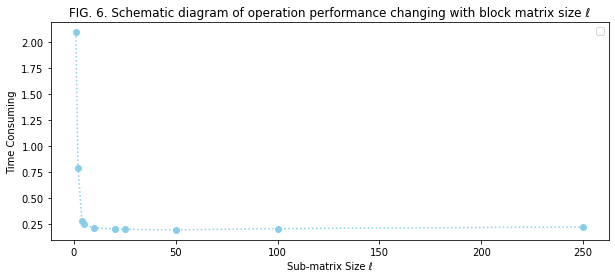

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(bsizes, timeit_block_l_results, ':',color='skyblue', marker = 'o')
plt.xlabel('Sub-matrix Size ℓ')
plt.ylabel('Time Consuming')
plt.title('FIG. 6. Schematic diagram of operation performance changing with block matrix size ℓ')
plt.legend()
plt.show()

According to the available images, the computational time of matrix block multiplication decreases as the size of the sub-matrix ℓ increases. When the value of ℓ increases within the range of, the calculation time is effectively reduced, and the calculation performance optimization effect is the most obvious. However, when ℓ exceeds, the optimization effect of the increase on the system's computing performance becomes insignificant.

Therefore, the strategy for a reasonable choice of ℓ is to select the inflection point in the performance optimization curve to maximize the optimization degree of matrix multiplication performance.

## Conclusion
<a id="conclusion"></a>

In summary, the time-consuming of matrix multiplication increases exponentially with the increase of the matrix size n, so optimizing its computing performance is of great significance for breaking through the computational limitations. In this article, we have used Numba serialization, Numba parallelization, and Numba column-first parallelization to optimize matrix multiplication and compare optimization performance. In addition, we also adopted a block strategy for further optimization. conclusion as below.

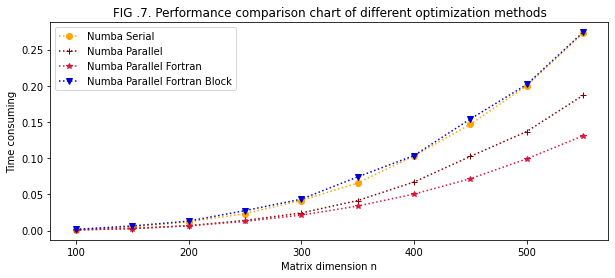

In [ ]:
x_fit = range(100, 600, 50)
plt.figure(figsize=(10,4))
plt.plot(x_fit,timeit_serial_results,
      ':',label='Numba Serial',color='orange', marker = 'o')
plt.plot(x_fit,timeit_parallel_results,
      ':',label='Numba Parallel',color='maroon',marker = '+')
plt.plot(x_fit,timeit_fortran_results,
      ':',label='Numba Parallel Fortran',color='crimson',marker = '*')
plt.plot(x_fit,timeit_block_results,
      ':',label='Numba Parallel Fortran Block',color='mediumblue',marker = 'v')
plt.xlabel('Matrix dimension n')
plt.ylabel('Time consuming')
plt.title('FIG .7. Performance comparison chart of different optimization methods')
plt.legend()
plt.show()

* Unoptimized matrix multiplication takes a very long time due to the high complexity of the algorithm, and there is a huge room for improvement in computing performance.
* The JIT compilation optimization in Numba has a very obvious optimization effect on matrix multiplication. Among them, parallel JIT compilation takes less time than serialized calculations.
* Due to the continuous addressing, the computational performance of column-first parallel matrix multiplication has been further improved, and the curve is smoother.
* Due to the high complexity, the optimization effect of block multiplication for matrix multiplication is not ideal, but the performance improvement of Numba for block multiplication is significant. In addition, the selection strategy of the sub-matrix size ℓ is the curve inflection point, which helps to most effectively improve the block computing performance.

According to the image, in the range of matrix size n from 100 to 600, Numba's parallelized matrix multiplication with B matrix column priority processing has the best computational performance, which is not only reflected in its shortest time-consuming, but also in its curve Smoother. The second is ordinary Numba's parallelized matrix multiplication. The two worst optimization methods are matrix block multiplication and Numba's serialized matrix multiplication. Their time result curves are staggered, which means that their optimization effects are similar.

Due to the limited computing power, this assignment did not involve the matrix size n greater than 550, so many curve characteristics have not been observed and further discussed. In addition, due to algorithm limitations, the situation when the block size ℓ cannot be divisible by n is not discussed. In future research, how to design a matrix multiplication with a lower complexity and perform effective optimization will be the breakthrough point to improve the computing power of computing clusters. In addition, joint discussions on computing power and cache capacity, cache hit efficiency and other hardware performance are also developing. One of the directions.

## Reference
<a id="reference"></a>

[1] Gao J , YuWang, JunWang. A novel multi–graphics processing unit parallel optimization framework for the sparse matrix‐vector multiplication[J]. Concurrency and Computation: Practice and Experience, 2017, 29(5):1-13.

[2] Ahmad A ,  Hatem L ,  David K , et al. Performance optimization of Sparse Matrix‐Vector Multiplication for multi‐component PDE‐based applications using GPUs[J]. Concurrency & Computation Practice & Experience, 2016, 28(12):3447-3465.

[3] Malik T ,  Rychkov V ,  Lastovetsky A . Network-aware optimization of communications for parallel matrix multiplication on hierarchical HPC platforms[J]. Concurrency and Computation: Practice and Experience, 2015.